# Install dependencies

In [ ]:
!pip install torch==1.6.0

#Define parameters

In [ ]:
import time
import os
import torch
class Config:
    n_features = 100
    batches_per_epoch = 100

    receiver_hidden = 600
    receiver_num_layers = 1
    receiver_embedding = 10
    receiver_cell = 'lstm'
    receiver_entropy_coeff = 0.1

    sender_hidden = 350
    sender_num_layers = 1
    sender_embedding = 10
    sender_cell = 'lstm'
    sender_entropy_coeff = 2.

    length_cost = 0.
    name = 'model'
    early_stopping_thr = 0.9999

    dir_save = 'dir_save'#'expe_'+str(time.time()).split('.')[0]
    checkpoint_dir = None#os.path.join('expe_'+str(time.time()).split('.')[0],'checkpoint')

    impatient = True
    reg = False
    random_seed = 42
    lr = 0.001
    unigram_pen = 0.

    force_eos = False

    batch_size = 512
    n_epochs = 501
    optimizer_class = torch.optim.Adam
    vocab_size = 40
    max_len = 30
    validation_freq = 1
    device = 'cuda:0'

    load_from_checkpoint = None
    checkpoint_freq = 0
    preemptable = False

# Setup training

In [ ]:
# Clone repository
! git clone https://github.com/Daetheys/Lazimpa.git
! mv "./Lazimpa/egg" "./egg"
! mv "./Lazimpa/example" "./example"

fatal: destination path 'Lazimpa' already exists and is not an empty directory.
mv: cannot stat './Lazimpa/egg': No such file or directory
mv: cannot stat './Lazimpa/example': No such file or directory


In [ ]:
! mkdir -p dir_save/{accuracy,messages,sender,receiver}
! mkdir analysis

/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: ` mkdir -p dir_save/([0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.02, 0.04, 0.05, 0.08, 0.11, 0.09, 0.07, 0.11, 0.12, 0.1, 0.13, 0.13, 0.14, 0.15, 0.15, 0.16, 0.15, 0.15, 0.16, 0.19, 0.17, 0.19, 0.19, 0.21, 0.16, 0.12, 0.15, 0.2, 0.25, 0.2, 0.26, 0.26, 0.3, 0.33, 0.34, 0.32, 0.37, 0.41, 0.45, 0.45, 0.46, 0.48, 0.47, 0.54, 0.55, 0.56, 0.55, 0.6, 0.59, 0.66, 0.62, 0.67, 0.71, 0.75, 0.65, 0.54, 0.78, 0.74, 0.84, 0.87, 0.86, 0.87, 0.87, 0.86, 0.9, 0.91, 0.92, 0.92, 0.94, 0.93, 0.95, 0.94, 0.84, 0.93, 0.96, 0.94, 0.86, 0.98, 0.98, 0.62, 0.81, 0.98, 0.98, 0.81, 0.81, 0.98, 0.85, 0.95, 0.96, 0.97, 0.98, 0.98, 0.97, 0.98, 0.98, 0.97, 0.97, 0.98, 0.98, 0.73, 0.7, 0.77, 0.92, 0.98, 0.96, 0.98, 0.97, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.97, 0.97, 0.98, 0.98, 0.96, 0.98, 0.98, 0.98, 0.96, 0.97, 0.98, 0.98, 0.98, 0.98, 0.98, 0.95, 0.97, 0.97, 0.97, 0.91, 0.99, 0.99, 0.98, 0.99, 0.99, 

In [ ]:
import json
import argparse
import numpy as np
import torch.utils.data
import torch.nn.functional as F
import egg.core as core
from egg.core import EarlyStopperAccuracy
from egg.zoo.channel.features import OneHotLoader, UniformLoader
from egg.zoo.channel.archs import Sender, Receiver
from egg.core.reinforce_wrappers import RnnReceiverImpatient
from egg.core.reinforce_wrappers import SenderImpatientReceiverRnnReinforce
from egg.core.util import dump_sender_receiver_impatient
from egg.zoo.channel.train import loss,loss_impatient,dump,dump_impatient

In [ ]:
import egg
config = Config()
egg.core.util.common_opts = config

#probs = np.ones(config.n_features) #uniform
probs = 1 / np.arange(1, config.n_features+1, dtype=np.float32) #powerlaw
#probs = np.array([float(x) for x in opts.probs.split(',')], dtype=np.float32) #else

probs /= probs.sum()

print('the probs are: ', probs, flush=True)


train_loader = OneHotLoader(n_features=config.n_features, batch_size=config.batch_size,
                            batches_per_epoch=config.batches_per_epoch, probs=probs)

# single batches with 1s on the diag
test_loader = UniformLoader(config.n_features)

sender = Sender(n_features=config.n_features, n_hidden=config.sender_hidden)

sender = core.RnnSenderReinforce(sender,
                                config.vocab_size, config.sender_embedding, config.sender_hidden,
                                cell=config.sender_cell, max_len=config.max_len, num_layers=config.sender_num_layers,
                                force_eos=config.force_eos)

receiver = Receiver(n_features=config.receiver_hidden, n_hidden=config.vocab_size)

if config.impatient:
    receiver = RnnReceiverImpatient(receiver, config.vocab_size, config.receiver_embedding,
                                        config.receiver_hidden, cell=config.receiver_cell,
                                        num_layers=config.receiver_num_layers, max_len=config.max_len, n_features=config.n_features)
else:
    receiver = core.RnnReceiverDeterministic(receiver, config.vocab_size, config.receiver_embedding,
                                                 config.receiver_hidden, cell=config.receiver_cell,
                                                 num_layers=config.receiver_num_layers)

game = SenderImpatientReceiverRnnReinforce(sender, receiver, loss_impatient, sender_entropy_coeff=config.sender_entropy_coeff,
                                        receiver_entropy_coeff=config.receiver_entropy_coeff,
                                        length_cost=config.length_cost,unigram_penalty=config.unigram_pen,reg=config.reg)

#optimizer = config.optimizer_class(game.parameters(),lr=config.lr)
optimizer = config.optimizer_class(game.parameters(),lr=config.lr)

trainer = core.Trainer(game=game, optimizer=optimizer, train_data=train_loader,
                        validation_data=test_loader, callbacks=[EarlyStopperAccuracy(config.early_stopping_thr)])


the probs are:  [0.1927756  0.0963878  0.06425854 0.0481939  0.03855512 0.03212927
 0.02753937 0.02409695 0.02141951 0.01927756 0.01752505 0.01606463
 0.01482889 0.01376969 0.01285171 0.01204848 0.01133974 0.01070976
 0.01014608 0.00963878 0.00917979 0.00876253 0.00838155 0.00803232
 0.00771102 0.00741445 0.00713984 0.00688484 0.00664743 0.00642585
 0.00621857 0.00602424 0.00584168 0.00566987 0.00550787 0.00535488
 0.00521015 0.00507304 0.00494296 0.00481939 0.00470184 0.0045899
 0.00448315 0.00438126 0.0042839  0.00419077 0.00410161 0.00401616
 0.0039342  0.00385551 0.00377991 0.00370722 0.00363728 0.00356992
 0.00350501 0.00344242 0.00338203 0.00332372 0.00326738 0.00321293
 0.00316026 0.00310928 0.00305993 0.00301212 0.00296578 0.00292084
 0.00287725 0.00283494 0.00279385 0.00275394 0.00271515 0.00267744
 0.00264076 0.00260508 0.00257034 0.00253652 0.00250358 0.00247148
 0.0024402  0.0024097  0.00237995 0.00235092 0.0023226  0.00229495
 0.00226795 0.00224158 0.00221581 0.00219063 0.

# Train

In [ ]:
for epoch in range(int(config.n_epochs)):

    print("Epoch: "+str(epoch))

    if epoch%100==0:
        trainer.optimizer.defaults["lr"]/=2

    trainer.train(n_epochs=1)
    if config.checkpoint_dir:
        trainer.save_checkpoint(name=f'{config.name}_vocab{config.vocab_size}_rs{config.random_seed}_lr{config.lr}_shid{config.sender_hidden}_rhid{config.receiver_hidden}_sentr{config.sender_entropy_coeff}_reg{config.length_cost}_max_len{config.max_len}')

    acc_vec,messages=dump_impatient(trainer.game, config.n_features, config.device, False,epoch)

    # ADDITION TO SAVE MESSAGES
    all_messages=[]
    for x in messages:
        x = x.cpu().numpy()
        all_messages.append(x)
    all_messages = np.asarray(all_messages)

    if epoch%200==0:
        torch.save(sender.state_dict(), config.dir_save+"/sender/sender_weights"+str(epoch)+".pth")
        torch.save(receiver.state_dict(), config.dir_save+"/receiver/receiver_weights"+str(epoch)+".pth")
        #print(acc_vec)

    np.save(config.dir_save+'/messages/messages_'+str((epoch))+'.npy', all_messages)
    np.save(config.dir_save+'/accuracy/accuracy_'+str((epoch))+'.npy', acc_vec)

core.close()

Epoch: 0
Impatient score=30
input: 0 -> message: 23,23,23,23,23,23,20,20,3,32,3,19,19,25,11,19,19,19,25,11,19,19,25,11,19,19,25,11,19,19 -> output: 0
input: 1 -> message: 23,23,23,23,30,23,30,23,30,39,30,11,32,19,25,11,19,19,19,25,11,19,19,25,11,19,19,25,11,19 -> output: 0
input: 2 -> message: 23,23,23,30,23,30,23,30,39,30,11,32,19,25,11,19,19,19,25,11,19,19,25,11,19,19,25,11,19,19 -> output: 0
input: 3 -> message: 23,23,23,30,23,30,23,30,39,30,11,32,19,25,11,19,19,19,25,11,19,19,25,11,19,19,25,11,19,19 -> output: 0
input: 4 -> message: 23,23,23,30,23,30,23,30,39,30,11,32,19,25,11,19,19,19,25,11,19,19,25,11,19,19,25,11,19,19 -> output: 0
input: 5 -> message: 23,23,30,23,30,23,30,39,30,11,32,19,25,11,19,19,19,25,11,19,19,25,11,19,19,25,11,19,19,25 -> output: 0
input: 6 -> message: 23,23,23,30,23,30,23,30,39,30,11,32,19,25,11,19,19,19,25,11,19,19,25,11,19,19,25,11,19,19 -> output: 0
input: 7 -> message: 23,23,30,23,30,23,30,39,30,11,32,19,25,11,19,19,19,25,11,19,19,25,11,19,19,25,11,19,1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Impatient score=55
Epoch: 3
Impatient score=38
Epoch: 4
Impatient score=31
Epoch: 5
Impatient score=45
Epoch: 6
Impatient score=63
Epoch: 7
Impatient score=90
Epoch: 8
Impatient score=135
Epoch: 9
Impatient score=149
Epoch: 10
Impatient score=186
Epoch: 11
Impatient score=203
Epoch: 12
Impatient score=208
Epoch: 13
Impatient score=210
Epoch: 14
Impatient score=267
Epoch: 15
Impatient score=236
Epoch: 16
Impatient score=234
Epoch: 17
Impatient score=243
Epoch: 18
Impatient score=322
Epoch: 19
Impatient score=378
Epoch: 20
Impatient score=410
Epoch: 21
Impatient score=383
Epoch: 22
Impatient score=380
Epoch: 23
Impatient score=438
Epoch: 24
Impatient score=436
Epoch: 25
Impatient score=437
{"powerlaw": 0.5740680564194918, "unif": 0.16}
Epoch: 26
Impatient score=434
Epoch: 27
Impatient score=462
Epoch: 28
Impatient score=482
Epoch: 29
Impatient score=503
Epoch: 30
Impatient score=492
Epoch: 31
Impatient score=493
Epoch: 32
Impatient score=498
Epoch: 33
Impatient score=513
Epoch: 34
Impati

#Plot results

In [ ]:
# Useful functions (for analysis)
import numpy as np
import matplotlib.pyplot as plt

def load_message(expe):
  """
  Load messages stored during training procedure/
  Return numpy array with all the messages
  """
  np_load_old = np.load
  messages = np.load(expe,allow_pickle=True)
  np.load = np_load_old
  return messages

def img2gif(img_dir,output_file):
  """
  Transform a folder of images (img_dir) into a gif and save it with name output_file
  """
  ! pip install images2gif
  import glob
  from PIL import Image

  # filepaths
  import os
  files = os.listdir(img_dir)
  files = [ _ for _ in files if ".png" in _ ]
  files = [int((_.split("test"))[1].split(".")[0]) for _ in files]
  files.sort()
  fp_in= [img_dir+"/test"+str(_)+".png" for _ in files]
  fp_out = output_file

  img, *imgs = [Image.open(f).resize((800,200)) for f in fp_in]
  img.save(fp=fp_out, format='GIF', append_images=imgs,
          save_all=True, duration=60, loop=0)

**4. Accuracy = f(mean_length)**: co-evolution of the accuracy and mean message length: allow us to spot the beginning of the regularization (laziness)

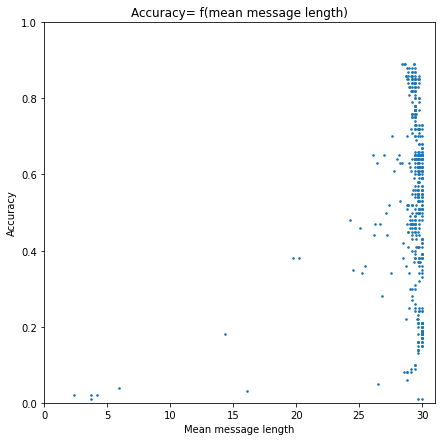

In [ ]:
mean_length_evolution=[]
accuracy=[]

for epoch in range(500):
  # Load messages
  messages=load_message("dir_save/messages/messages_"+str(epoch)+".npy")

  # Construct the length distribution
  length_distribution=[]
  for message in messages:
    length_distribution.append(len(message))
  
  # Get the mean length
  mean_length_evolution.append(np.mean(length_distribution))

  # Get the accuracy
  accuracy.append(np.mean(np.load("dir_save/accuracy/accuracy_"+str(epoch)+".npy")))

# Plot fig
fig, ax = plt.subplots(1, 1, figsize=(7,7))
ax.scatter(mean_length_evolution,accuracy,s=2.5)
ax.set_title("Accuracy= f(mean message length)")
ax.set_xlabel("Mean message length")
ax.set_ylabel("Accuracy")
ax.set_xlim((0,31))
ax.set_ylim((0,1))

plt.show()

# Save results

In [ ]:
#Creates folder with stats
!mkdir saved_stats

#Selects what to keep
!zip -r /content/saved_stats/accuracy.zip /content/dir_save/accuracy
!zip -r /content/saved_stats/messages.zip /content/dir_save/messages
!mv /content/dir_save/receiver/receiver_weights800.pth /content/saved_stats/receiver.pth
!mv /content/dir_save/sender/sender_weights800.pth /content/saved_stats/sender.pth

!zip -r /content/saved_stats.zip /content/saved_stats

!mv saved_stats.zip saved_stats_impatient.zip

#Downloads the file
from google.colab import files
files.download("/content/saved_stats_impatient.zip")

mkdir: cannot create directory ‘saved_stats’: File exists
updating: content/dir_save/accuracy/ (stored 0%)
updating: content/dir_save/accuracy/accuracy_387.npy (deflated 88%)
updating: content/dir_save/accuracy/accuracy_438.npy (deflated 89%)
updating: content/dir_save/accuracy/accuracy_347.npy (deflated 89%)
updating: content/dir_save/accuracy/accuracy_371.npy (deflated 89%)
updating: content/dir_save/accuracy/accuracy_415.npy (deflated 89%)
updating: content/dir_save/accuracy/accuracy_301.npy (deflated 89%)
updating: content/dir_save/accuracy/accuracy_37.npy (deflated 89%)
updating: content/dir_save/accuracy/accuracy_316.npy (deflated 89%)
updating: content/dir_save/accuracy/accuracy_290.npy (deflated 89%)
updating: content/dir_save/accuracy/accuracy_82.npy (deflated 90%)
updating: content/dir_save/accuracy/accuracy_125.npy (deflated 89%)
updating: content/dir_save/accuracy/accuracy_434.npy (deflated 89%)
updating: content/dir_save/accuracy/accuracy_3.npy (deflated 91%)
updating: con

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>